In [19]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.utils.data as Data
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

boston_X.shape (506, 13)


D:\envs\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
  

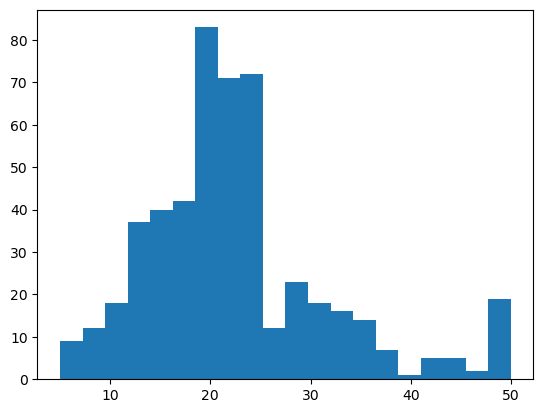

In [20]:
##读取数据
boston_X,boston_y =load_boston(return_X_y=True)
print("boston_X.shape",boston_X.shape)
plt.figure()
plt.hist(boston_y,bins=20)
plt.show()

In [21]:
##数据标准化处理
ss=StandardScaler(with_mean=True,with_std=True)
boston_Xs=ss.fit_transform(boston_X)
##将数据预处理为可以使用pyTorch进行批量训练的形式
##训练集x转化为张量
train_xt=torch.from_numpy(boston_Xs.astype(np.float32))
##训练集y转化为张量
train_yt=torch.from_numpy(boston_y.astype(np.float32))
##将训练集转化为张量后，使用TensorDataset将X和Y整理到一起
train_data=Data.TensorDataset(train_xt,train_yt)
##定义一个数据加载器，将训练数据集进行批量处理
train_loader=Data.DataLoader(
    dataset=train_data, ##使用的数据集
    batch_size=128,     ##批处理样本大小
    shuffle=True,       ##每次迭代前打乱数据
    num_workers=1,      ##使用两个进程
)

In [22]:
##使用继承Module的方式定义方式全链接神经网络
class MLPmodel(nn.Module):
    def __init__(self):
        super(MLPmodel,self).__init__()
        ##定义第一个隐藏层
        super().__init__()
        self.hidden1=nn.Linear(
            in_features=13,##第一个隐藏层的输入，数据的特征数
            out_features=10,##第一个隐藏层的输出，神经元的数量
            bias=True,##默认会有偏置
        )
        self.active1=nn.ReLU()
        ##定义第二个隐藏层
        self.hidden2=nn.Linear(10,10)
        self.active2=nn.ReLU()
        ##定义预测回归层
        self.regression=nn.Linear(10,1)
    ##定义网络的前向传播路径
    def forward(self,x):
        x=self.hidden1(x)
        x=self.active1(x)
        x=self.hidden2(x)
        x=self.active2(x)
        output=self.regression(x)
        ##输出为output
        return output

In [23]:
## 输出我们的网络结构
mlpl=MLPmodel()
print(mlpl)

MLPmodel(
  (hidden1): Linear(in_features=13, out_features=10, bias=True)
  (active1): ReLU()
  (hidden2): Linear(in_features=10, out_features=10, bias=True)
  (active2): ReLU()
  (regression): Linear(in_features=10, out_features=1, bias=True)
)


In [24]:
##对回归模型mlpl进行训练并输出损失函数的变化情况，定义优化器和损失函数
optimizer=SGD(mlpl.parameters(),lr=0.001)
loss_func=nn.MSELoss()##最小均方根误差
train_loss_all=[]##输出每个批次训练的损失函数
##进行训练，并输出每次迭代的损失函数
for epoch in range(30):
    ##对训练数据的加载器进行迭代计算
    for step ,(b_x,b_y) in enumerate(train_loader):
        output=mlpl(b_x).flatten()##MLP在训练batch上的输出
        train_loss=loss_func(output,b_y)##均方误差
        optimizer.zero_grad(),##每个迭代不的梯度初始化为0
        train_loss.backward()##损失的后向传播，计算梯度
        optimizer.step()
        train_loss_all.append(train_loss.item())

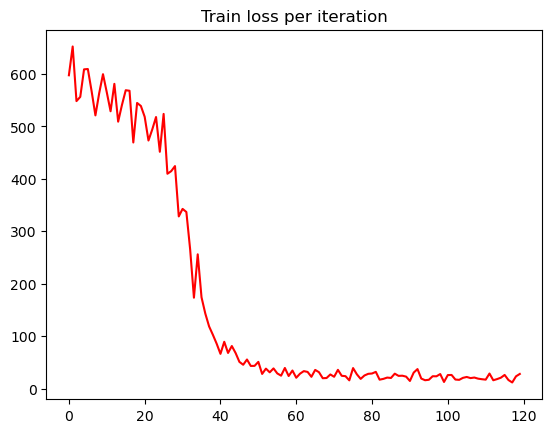

In [25]:
plt.figure()
plt.plot(train_loss_all,"r-")
plt.title("Train loss per iteration")
plt.show()

In [26]:
##使用定义网络时使用nn.Sequential的形式
class MLPmodel2(nn.Module):
    def __init__(self):
        super(MLPmodel2,self).__init__()
        ##定义隐藏层
        self.hidden=nn.Sequential(
            nn.Linear(13,10),
            nn.ReLU(),
            nn.Linear(10,10),
            nn.ReLU()
        )
        ##预测回归层
        self.regression=nn.Linear(10,1)
    ##定义前向传播的路径
    def forward(self,x):
        x=self.hidden(x)
        output=self.regression(x)
        return output

In [27]:
##输出网络架构
mlp2=MLPmodel2()
print(mlp2)

MLPmodel2(
  (hidden): Sequential(
    (0): Linear(in_features=13, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
  )
  (regression): Linear(in_features=10, out_features=1, bias=True)
)


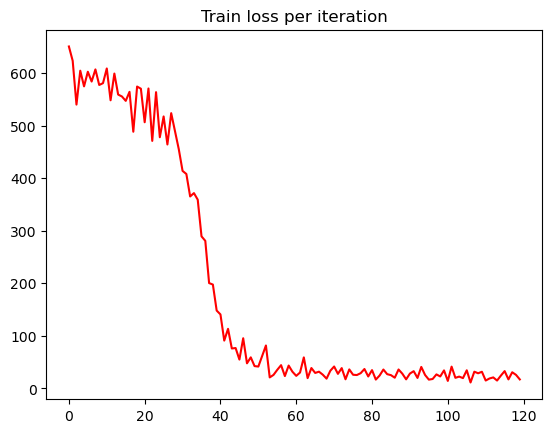

In [28]:
##对回归模型mlp2进行训练并输出损失函数的变化情况，定义优化器和损失函数
optimizer=SGD(mlp2.parameters(),lr=0.001)
loss_func=nn.MSELoss()  ##最小均方根误差
train_loss_all=[]       ##输出每个批次训练的损失函数
## 进行训练，并输出每次的迭代函数
for epoch in range(30):
    ##对训练数据的加载器进行迭代计算
    for step, (b_x,b_y) in enumerate(train_loader):
        output=mlp2(b_x).flatten() ##mlp在训练batch上的输出
        train_loss=loss_func(output,b_y) ##均方根误差
        optimizer.zero_grad() ##梯度清零
        train_loss.backward() ##反向传播
        optimizer.step()      ##使用梯度进行优化
        train_loss_all.append(train_loss.item())
plt.figure()
plt.plot(train_loss_all,"r-")
plt.title('Train loss per iteration')
plt.show()

In [29]:
##保存整个模型
torch.save(mlpl,"model/mlp1.pkl")
torch.save(mlp2,"model/mlp2.pkl")
##导入保存的模型
mlp2load=torch.load("model/mlp2.pkl")
mlp2load

MLPmodel2(
  (hidden): Sequential(
    (0): Linear(in_features=13, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
  )
  (regression): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
torch.save(mlp2.state_dict(),"model/mlp2_param.pkl")
##导入保存的模型的参数
mlp2param=torch.load("model/mlp2_param.pkl")
mlp2param

OrderedDict([('hidden.0.weight',
              tensor([[-0.1241, -0.3836,  0.3904,  0.1590,  0.2895,  0.1360, -0.0278, -0.3004,
                        0.5168,  0.2141, -0.1958,  0.1167, -0.3591],
                      [-0.3221, -0.2049,  0.1945, -0.2402, -0.0110,  0.1569, -0.1194, -0.2483,
                       -0.1160, -0.3375, -0.0067,  0.0161, -0.0234],
                      [-0.0905, -0.1985,  0.3237,  0.1962,  0.1864,  0.0287,  0.2160, -0.2542,
                        0.4000, -0.0206,  0.0645, -0.2023,  0.0029],
                      [-0.5104,  0.0150, -0.1016,  0.2759, -0.1728,  0.7007, -0.1924, -0.1999,
                       -0.5007, -0.6342, -0.0681,  0.5008, -0.5700],
                      [-0.1490,  0.2050,  0.1765, -0.2078,  0.1884,  0.2346,  0.0922,  0.1699,
                       -0.3309, -0.3456, -0.2084, -0.0740, -0.3892],
                      [ 0.0800, -0.1057,  0.1009, -0.1703, -0.2206, -0.0241,  0.1976,  0.0402,
                       -0.1725,  0.2336,  0.0255,  0